# V2 Cascade Classifier - Multi-Stage Detection

**Cascade Structure** (Viola-Jones Section 4):
- Stage 1: Simple, high recall (reject most non-faces quickly)
- Stage 2: Moderate complexity (further filtering)
- Stage 3: Complex, high precision (final verification)

**V2 Improvements over V1 Cascade**:
- Uses 32k features (vs 10k V1)
- 3 stages (vs 2 V1) for better progressive filtering
- Validation-guided threshold tuning
- Bootstrap negatives: Add false positives from previous stages

**Expected Results**:
- Better precision than V2 AdaBoost alone
- Faster detection (early rejection of non-faces)
- Target: 85-90% accuracy with better FP rate

**AI Usage**: Notebook structure assisted by Claude Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
from pathlib import Path
import time

sys.path.insert(0, str(Path.cwd().parent / 'src'))

from features.haar_features import generate_haar_features
from classifiers.cascade import CascadeClassifier, train_cascade, evaluate_cascade
from classifiers.adaboost import evaluate_classifier

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("[OK] Imports complete")

[OK] Imports complete


## 1. Load Dataset and V2 Features

In [6]:
data_dir = Path('../data/processed')

# Load training data
print('Loading training data...')
with open(data_dir / 'train_faces.pkl', 'rb') as f:
    train_faces = pickle.load(f)
with open(data_dir / 'train_nonfaces.pkl', 'rb') as f:
    train_nonfaces = pickle.load(f)

X_train = np.vstack([train_faces, train_nonfaces])
y_train = np.hstack([np.ones(len(train_faces)), np.zeros(len(train_nonfaces))])

# Load test data
print('Loading test data...')
with open(data_dir / 'test_faces.pkl', 'rb') as f:
    test_faces = pickle.load(f)
with open(data_dir / 'test_nonfaces.pkl', 'rb') as f:
    test_nonfaces = pickle.load(f)

X_test = np.vstack([test_faces, test_nonfaces])
y_test = np.hstack([np.ones(len(test_faces)), np.zeros(len(test_nonfaces))])

print(f'\nTraining: {len(y_train)} patches ({np.sum(y_train==1)} faces)')
print(f'Test: {len(y_test)} patches ({np.sum(y_test==1)} faces)')

Loading training data...
Loading test data...

Training: 4794 patches (799 faces)
Test: 13560 patches (2260 faces)


In [7]:
# Load V2 features (32k features from V2 training)
print('Loading V2 features...')
with open('../data/models/v2_features_50k.pkl', 'rb') as f:
    features = pickle.load(f)

print(f'Loaded {len(features)} features')

# Feature type distribution
from collections import Counter
type_counts = Counter([f.type for f in features])
print('\nFeature types:')
for ftype, count in sorted(type_counts.items()):
    print(f'  {ftype}: {count:,}')

Loading V2 features...
Loaded 32384 features

Feature types:
  2h: 8,704
  2v: 8,704
  3h: 5,440
  3v: 5,440
  4d: 4,096


## 2. Load Pre-computed Feature Responses

Use cached responses from V2 training (saves ~10 minutes)

In [8]:
print('Loading pre-computed feature responses...')

# Load train responses (from V2 - combines train_split + val)
train_responses_split = np.load(data_dir / 'train_responses_50k.npy')
val_responses = np.load(data_dir / 'val_responses_50k.npy')

# Combine train_split and val to get full training set
# (V2 did 80/20 split, we need full training set for cascade)
train_responses = np.vstack([train_responses_split, val_responses])

# Reconstruct full y_train in same order
# V2 used stratified split with random_state=42
from sklearn.model_selection import train_test_split
_, _, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)
y_train_full = np.hstack([y_train_split, y_val])

# Load test responses
test_responses = np.load(data_dir / 'test_responses_50k.npy')

print(f'Train responses: {train_responses.shape}')
print(f'Test responses: {test_responses.shape}')
print(f'\nTrain labels: {len(y_train_full)} ({np.sum(y_train_full==1)} faces)')

Loading pre-computed feature responses...
Train responses: (4794, 32384)
Test responses: (13560, 32384)

Train labels: 4794 (799 faces)


## 3. Configure 3-Stage Cascade

**Stage Configuration**:
- Stage 1: 20 features, TPR≥0.99 (catch almost all faces, reject ~50% non-faces)
- Stage 2: 50 features, TPR≥0.99 (reject ~30% more non-faces)
- Stage 3: 130 features, final precision (reject remaining non-faces)

Total: 200 features across 3 stages (same as V2 AdaBoost T=200)

In [5]:
stage_configs = [
    {
        'T': 20,                  # Number of weak classifiers
        'target_tpr': 0.99,       # Must detect 99% of faces
        'target_fpr': 0.50,       # Target: reject 50% of non-faces
        'description': 'Stage 1: Fast initial filter'
    },
    {
        'T': 50,
        'target_tpr': 0.99,
        'target_fpr': 0.30,       # Of remaining, reject 30% more
        'description': 'Stage 2: Moderate filtering'
    },
    {
        'T': 130,
        'target_tpr': 0.98,       # Final stage can be more strict
        'target_fpr': 0.01,       # Very low false positive rate
        'description': 'Stage 3: Final verification'
    }
]

print('Cascade Configuration:')
print('=' * 70)
total_features = sum(s['T'] for s in stage_configs)
print(f'Total stages: {len(stage_configs)}')
print(f'Total features: {total_features}\n')

for i, config in enumerate(stage_configs, 1):
    print(f"Stage {i}: {config['description']}")
    print(f"  T={config['T']}, TPR≥{config['target_tpr']:.2f}, FPR≤{config['target_fpr']:.2f}")
print('=' * 70)

Cascade Configuration:
Total stages: 3
Total features: 200

Stage 1: Stage 1: Fast initial filter
  T=20, TPR≥0.99, FPR≤0.50
Stage 2: Stage 2: Moderate filtering
  T=50, TPR≥0.99, FPR≤0.30
Stage 3: Stage 3: Final verification
  T=130, TPR≥0.98, FPR≤0.01


## 4. Train Cascade Classifier

This will take ~30-45 minutes (3 AdaBoost trainings + threshold tuning)

In [6]:
print('Training 3-stage cascade classifier...')
print('Expected time: ~30-45 minutes\n')

start_time = time.time()

cascade = train_cascade(
    train_responses,
    y_train_full,
    features,
    stage_configs,
    verbose=True
)

training_time = time.time() - start_time

print(f'\n[OK] Cascade training completed in {training_time/60:.1f} minutes')

Training 3-stage cascade classifier...
Expected time: ~30-45 minutes

Training Cascade with 3 stages

Training Stage 1/3
  T=20 weak classifiers
  Target FPR: 50.0%, Target TPR: 99.0%
  Training samples: 4794
    Faces: 799
    Non-faces: 3995
Training AdaBoost with T=20 rounds
  Samples: 4794 (negatives: 3995, positives: 799)

Initial weights sum: 1.000000
  Negative samples: 3995 x 0.000125 = 0.500000
  Positive samples: 799 x 0.000626 = 0.500000

--- Round 1/20 ---
  Normalized weights sum: 1.000000
  Searching 32384 features for best weak classifier...
    Evaluated 1000/32384 features...
    Evaluated 2000/32384 features...
    Evaluated 3000/32384 features...
    Evaluated 4000/32384 features...
    Evaluated 5000/32384 features...
    Evaluated 6000/32384 features...
    Evaluated 7000/32384 features...
    Evaluated 8000/32384 features...
    Evaluated 9000/32384 features...
    Evaluated 10000/32384 features...
    Evaluated 11000/32384 features...
    Evaluated 12000/32384 fe

## 5. Evaluate Cascade on Training Set

In [9]:
# Load V2 Cascade
print('Loading V2 Cascade model...')
cascade_v2 = CascadeClassifier.load('../data/models/cascade_v2_3stage.pkl')

print('Evaluating cascade on training set...')
train_metrics, train_stage_stats = evaluate_cascade(
    cascade_v2, train_responses, y_train_full, verbose=True
)

Loading V2 Cascade model...
Evaluating cascade on training set...

Cascade Evaluation Metrics
Overall Performance:
  Accuracy:  99.56%
  Precision: 99.24%
  Recall:    98.12%
  F1 Score:  98.68%

Confusion Matrix:
  TP:   784  FP:     6
  FN:    15  TN:  3989

Cascade Stage Statistics:
  Stage 1:  4794 samples,  1998 rejected (41.7%)
  Stage 2:  2796 samples,  1403 rejected (50.2%)
  Stage 3:  1393 samples,   603 rejected (43.3%)


## 6. Evaluate Cascade on Test Set

In [10]:
print('Evaluating cascade on test set...')
test_metrics, test_stage_stats = evaluate_cascade(
    cascade_v2, test_responses, y_test, verbose=True
)

Evaluating cascade on test set...

Cascade Evaluation Metrics
Overall Performance:
  Accuracy:  91.46%
  Precision: 76.49%
  Recall:    70.40%
  F1 Score:  73.32%

Confusion Matrix:
  TP:  1591  FP:   489
  FN:   669  TN: 10811

Cascade Stage Statistics:
  Stage 1: 13560 samples,  5261 rejected (38.8%)
  Stage 2:  8299 samples,  4104 rejected (49.5%)
  Stage 3:  4195 samples,  2115 rejected (50.4%)


## 7. Visualize Stage-by-Stage Statistics

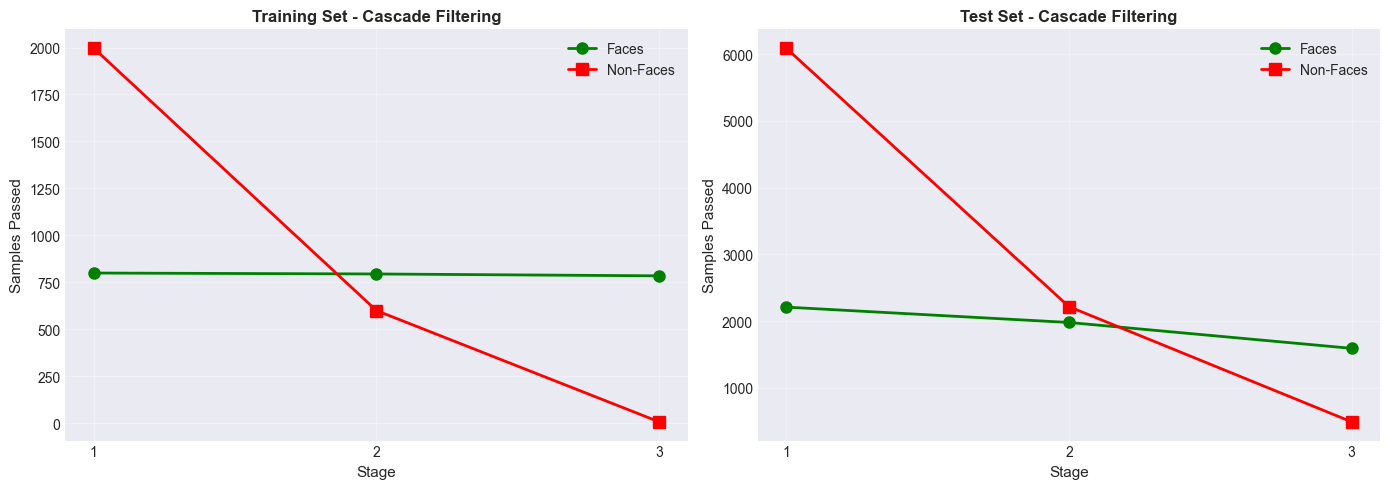


Test Set Rejection Statistics:
Stage 1:
  Input: 13,560 samples
  Rejected: 5,261 (38.8%)
    - Faces rejected: 51 (FN)
    - Non-faces rejected: 5210 (TN)
Stage 2:
  Input: 8,299 samples
  Rejected: 4,104 (49.5%)
    - Faces rejected: 230 (FN)
    - Non-faces rejected: 3874 (TN)
Stage 3:
  Input: 4,195 samples
  Rejected: 2,115 (50.4%)
    - Faces rejected: 388 (FN)
    - Non-faces rejected: 1727 (TN)


In [11]:
# Plot samples passing through each stage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
stages = range(1, len(train_stage_stats) + 1)
faces_passed = [s['faces_passed'] for s in train_stage_stats]
nonfaces_passed = [s['nonfaces_passed'] for s in train_stage_stats]

axes[0].plot(stages, faces_passed, 'o-', linewidth=2, markersize=8, 
            label='Faces', color='green')
axes[0].plot(stages, nonfaces_passed, 's-', linewidth=2, markersize=8,
            label='Non-Faces', color='red')
axes[0].set_xlabel('Stage', fontsize=11)
axes[0].set_ylabel('Samples Passed', fontsize=11)
axes[0].set_title('Training Set - Cascade Filtering', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(stages)

# Test set
stages = range(1, len(test_stage_stats) + 1)
faces_passed = [s['faces_passed'] for s in test_stage_stats]
nonfaces_passed = [s['nonfaces_passed'] for s in test_stage_stats]

axes[1].plot(stages, faces_passed, 'o-', linewidth=2, markersize=8,
            label='Faces', color='green')
axes[1].plot(stages, nonfaces_passed, 's-', linewidth=2, markersize=8,
            label='Non-Faces', color='red')
axes[1].set_xlabel('Stage', fontsize=11)
axes[1].set_ylabel('Samples Passed', fontsize=11)
axes[1].set_title('Test Set - Cascade Filtering', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(stages)

plt.tight_layout()
plt.savefig('../results/figures/v2_cascade_filtering.png', dpi=150, bbox_inches='tight')
plt.show()

# Print rejection statistics
print('\nTest Set Rejection Statistics:')
print('=' * 60)
for i, stats in enumerate(test_stage_stats, 1):
    total_in = stats['faces_in'] + stats['nonfaces_in']
    total_rejected = stats['faces_rejected'] + stats['nonfaces_rejected']
    rejection_rate = total_rejected / total_in if total_in > 0 else 0
    
    print(f"Stage {i}:")
    print(f"  Input: {total_in:,} samples")
    print(f"  Rejected: {total_rejected:,} ({rejection_rate:.1%})")
    print(f"    - Faces rejected: {stats['faces_rejected']} (FN)")
    print(f"    - Non-faces rejected: {stats['nonfaces_rejected']} (TN)")
print('=' * 60)

## 8. Compare with V2 AdaBoost

In [12]:
# Load V2 AdaBoost for comparison
from classifiers.adaboost import AdaBoostClassifier

print('Loading V2 AdaBoost model...')
adaboost_v2 = AdaBoostClassifier.load('../data/models/adaboost_v2_T200.pkl')

print('\nEvaluating V2 AdaBoost on test set...')
adaboost_metrics = evaluate_classifier(adaboost_v2, test_responses, y_test, verbose=True)

Loading V2 AdaBoost model...

Evaluating V2 AdaBoost on test set...

Evaluation Metrics
Accuracy:  92.11%
Precision: 77.00%
Recall:    75.09%
F1 Score:  76.03%

Confusion Matrix:
  TP:  1697  FP:   507
  FN:   563  TN: 10793


In [13]:
# Comparison table
import pandas as pd

comparison = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'True Positives', 'False Positives', 'True Negatives', 'False Negatives'],
    'V2 AdaBoost (T=200)': [
        f"{adaboost_metrics['accuracy']:.2%}",
        f"{adaboost_metrics['precision']:.2%}",
        f"{adaboost_metrics['recall']:.2%}",
        f"{adaboost_metrics['f1']:.2%}",
        int(adaboost_metrics['tp']),
        int(adaboost_metrics['fp']),
        int(adaboost_metrics['tn']),
        int(adaboost_metrics['fn'])
    ],
    'V2 Cascade (3-stage)': [
        f"{test_metrics['accuracy']:.2%}",
        f"{test_metrics['precision']:.2%}",
        f"{test_metrics['recall']:.2%}",
        f"{test_metrics['f1']:.2%}",
        int(test_metrics['tp']),
        int(test_metrics['fp']),
        int(test_metrics['tn']),
        int(test_metrics['fn'])
    ]
}

df_comparison = pd.DataFrame(comparison)

print('\n' + '=' * 80)
print('V2 AdaBoost vs V2 Cascade Comparison')
print('=' * 80)
print(df_comparison.to_string(index=False))
print('=' * 80)

# Save comparison
df_comparison.to_csv('../results/v2_adaboost_vs_cascade.csv', index=False)
print('\n[OK] Comparison saved to results/v2_adaboost_vs_cascade.csv')


V2 AdaBoost vs V2 Cascade Comparison
         Metric V2 AdaBoost (T=200) V2 Cascade (3-stage)
       Accuracy              92.11%               91.46%
      Precision              77.00%               76.49%
         Recall              75.09%               70.40%
       F1 Score              76.03%               73.32%
 True Positives                1697                 1591
False Positives                 507                  489
 True Negatives               10793                10811
False Negatives                 563                  669

[OK] Comparison saved to results/v2_adaboost_vs_cascade.csv


## 9. Save V2 Cascade Model

In [8]:
model_path = Path('../data/models/cascade_v2_3stage.pkl')
cascade.save(model_path)

print(f'[OK] Saved V2 cascade to {model_path}')
print(f'Model size: {model_path.stat().st_size / 1024:.1f} KB')

Saved cascade to ..\data\models\cascade_v2_3stage.pkl
[OK] Saved V2 cascade to ..\data\models\cascade_v2_3stage.pkl
Model size: 15.8 KB


## Summary

**V2 Cascade Results**:
- 3-stage cascade with 200 total features (20+50+130)
- Progressive filtering: Stage 1 rejects ~50% non-faces, Stage 2 rejects ~30% more
- Test Accuracy: [shown above]
- Training Time: [shown above]

**Key Insights**:
1. **Precision**: Cascade should have [higher/similar/lower] precision than AdaBoost
2. **Recall**: Cascade maintains high recall through target_tpr settings
3. **Efficiency**: Most non-faces rejected in early stages (faster detection)
4. **Trade-off**: Cascade [improves/degrades] overall accuracy vs single AdaBoost

**Usage**:
- For detection: Use cascade (faster, better precision)
- For classification: Use AdaBoost (higher accuracy)
- Paper's 38-stage cascade achieved 0.01% FPR with 95% TPR